**This project involves the development of a content-based recommendation engine that should take the name of a skincare product as input and return several similar products based on the product's ingredients.**

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from bokeh.io import curdoc, push_notebook, output_notebook
from bokeh.layouts import column, layout
from bokeh.models import ColumnDataSource, Div, Select, Slider, TextInput, HoverTool
from bokeh.plotting import figure, show
from ipywidgets import interact, interactive, fixed, interact_manual

In [ ]:
data=pd.read_csv("/content/skincare_products_clean.csv")

In [ ]:
data.head()

,product_name,product_url,product_type,clean_ingreds,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"['capric triglyceride', 'cetyl alcohol', 'prop...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"['homosalate', 'glycerin', 'octocrylene', 'eth...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"['sodium hyaluronate', 'sodium hyaluronate', '...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"['ammonium lactate', 'c12-15', 'glycerin', 'pr...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"['glycerin', 'cetearyl alcohol', 'capric trigl...",£16.00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   1138 non-null   object
 1   product_url    1138 non-null   object
 2   product_type   1138 non-null   object
 3   clean_ingreds  1138 non-null   object
 4   price          1138 non-null   object
dtypes: object(5)
memory usage: 44.6+ KB


**Dataset has 1138 rows and 5 colums**

**We can see that there are no missing values**

In [ ]:
data.describe()

,product_name,product_url,product_type,clean_ingreds,price
count,1138,1138,1138,1138,1138
unique,1138,1126,14,1071,290
top,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/lancome-advanced...,Mask,['sodium chloride'],£22.00
freq,1,4,124,5,33


In [ ]:
for i in range(len(data['clean_ingreds'])):
    data['clean_ingreds'].iloc[i] = str(data['clean_ingreds'].iloc[i]).replace('[', '').replace(']', '').replace("'", '').replace('"', '')
#performs a series of string replacement operations

In [ ]:
all_ingreds = []

for i in data['clean_ingreds']:
    ingreds_list = i.split(', ')
    for j in ingreds_list:
        all_ingreds.append(j)
#splitting each element into individual ingredient strings based on commas (',').
#It then collects all these individual ingredient strings into a single list called all_ingreds.

In [ ]:
all_ingreds = sorted(set(all_ingreds))  #Converts the list all_ingreds into a set to remove any duplicate ingredients (since sets only store unique elements)
all_ingreds[0:20]

['',
 '1,10-decanediol',
 '1,2-hexanediol',
 '1,2-hexanediol ',
 '1-methylhydantoin-2-imide',
 '10-hydroxydecanoic acid',
 '2,6-dimethyl-7-octen-2-ol',
 '2-bromo-2-nitropropane-1,3-diol',
 '2-oleamido-1',
 '3-o-ethyl ascorbic acid',
 '3-octadecanediol',
 '4-t-butylcyclohexanol',
 '7-dehydrocholesterol',
 'abies alba leaf oil',
 'abies balsamea extract',
 'abies sibirica oil',
 'acacia concinna fruit extract',
 'acacia decurrens wax',
 'acacia senegal gum',
 'acacia seyal gum extract']

In [ ]:
all_ingreds.remove('')  #Removing Empty Strings
for i in range(len(all_ingreds)):   #Removing Trailing Spaces
    if all_ingreds[i][-1] == ' ':
        all_ingreds[i] = all_ingreds[i][0:-1]

all_ingreds = sorted(set(all_ingreds))  #Sorting and Removing Duplicates
all_ingreds[0:20]

['1,10-decanediol',
 '1,2-hexanediol',
 '1-methylhydantoin-2-imide',
 '10-hydroxydecanoic acid',
 '2,6-dimethyl-7-octen-2-ol',
 '2-bromo-2-nitropropane-1,3-diol',
 '2-oleamido-1',
 '3-o-ethyl ascorbic acid',
 '3-octadecanediol',
 '4-t-butylcyclohexanol',
 '7-dehydrocholesterol',
 'abies alba leaf oil',
 'abies balsamea extract',
 'abies sibirica oil',
 'acacia concinna fruit extract',
 'acacia decurrens wax',
 'acacia senegal gum',
 'acacia seyal gum extract',
 'acer saccharum extract',
 'acetate']

In [ ]:
one_hot_list = [[0] * 0 for i in range(len(all_ingreds))]

for i in data['clean_ingreds']:   #Generating One-Hot Encoding
    k=0
    for j in all_ingreds:
        if j in i:
            one_hot_list[k].append(1)
        else:
            one_hot_list[k].append(0)
        k+=1

#If j is present in i, it appends 1 to the corresponding inner list in one_hot_list[k].
#If j is not present in i, it appends 0 to the corresponding inner list in one_hot_list[k].
#Here, k is used to keep track of the index of the ingredient in all_ingreds.
ingred_matrix = pd.DataFrame(one_hot_list).transpose()
ingred_matrix.columns = [sorted(set(all_ingreds))]

ingred_matrix

,"1,10-decanediol","1,2-hexanediol",1-methylhydantoin-2-imide,10-hydroxydecanoic acid,"2,6-dimethyl-7-octen-2-ol","2-bromo-2-nitropropane-1,3-diol",2-oleamido-1,3-o-ethyl ascorbic acid,3-octadecanediol,4-t-butylcyclohexanol,...,zinc glycine,zinc laurate,zinc oxide,zinc pca,zinc sulfate,zingiber aromaticus extract,zingiber cassumunar root oil,zingiber officinale root extract,zingiber officinale root oil,zizyphus jujuba seed extract
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**This matrix contains zeros and ones**

***In summary, this code snippet is generating a one-hot encoded matrix (ingred_matrix) to represent the presence or absence of each ingredient in each product based on their ingredient lists (clean_ingreds). The matrix is constructed using a list of lists (one_hot_list), where each inner list corresponds to an ingredient and stores binary values (0 or 1) indicating ingredient presence. The resulting DataFrame (ingred_matrix) is then transposed for a more conventional representation, with column names set to the sorted list of unique ingredients.***

**Dimentionality Reduction
**

In [ ]:
#We will use TruncatedSVD and TSNE to summarise the whole matrix in 2 values for each row.
#These x and y values can be plotted to visualise the similarities between the products.

In [ ]:
svd = TruncatedSVD(n_components=150, n_iter = 1000, random_state = 6) # firstly reduce features to 150 with truncatedSVD - this suppresses some noise
svd_features = svd.fit_transform(ingred_matrix)

tsne = TSNE(n_components = 2, n_iter = 1000000, random_state = 6) # reduce 150 features to 2 using t-SNE with exact method
tsne_features = tsne.fit_transform(svd_features)

data['X'] = tsne_features[:, 0]
data['Y'] = tsne_features[:, 1]

->TruncatedSVD is a dimensionality reduction technique that uses singular value
decomposition (SVD) to reduce the number of features (columns) in a matrix while preserving as much variance as possible.
->TSNE is another dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D.

In [ ]:
unique_types = ['Moisturiser', 'Serum', 'Oil', 'Mist', 'Balm', 'Mask', 'Peel',
       'Eye Care', 'Cleanser', 'Toner', 'Exfoliator', 'Bath Salts',
       'Body Wash', 'Bath Oil']   #all the unique products

source = ColumnDataSource(data)

In [ ]:
#creating bokeh plot
plot = figure(title = "Mapped Similarities", width = 800, height = 600)
plot.xaxis.axis_label = "t-SNE 1"
plot.yaxis.axis_label = 't-SNE 2'

plot.circle(x = 'X', y = 'Y', source = source, fill_alpha=0.7, size=10,
           color = '#c0a5e3', alpha = 1)

plot.background_fill_color = "#E9E9E9"
plot.background_fill_alpha = 0.3

hover = HoverTool(tooltips=[('Product', '@product_name'), ('Price', '@price')])
plot.add_tools(hover)

def type_updater(product_type = unique_types[0]):
    new_data = {'X' : data[data['product_type'] == product_type]['X'],
                'Y' : data[data['product_type'] == product_type]['Y'],
                'product_name' : data[data['product_type'] == product_type]['product_name'],
                'price' : data[data['product_type'] == product_type]['price']}
    source.data = new_data
    push_notebook()

output_notebook()
show(plot, notebook_handle = True)
interact(type_updater, product_type = unique_types)

interactive(children=(Dropdown(description='product_type', options=('Moisturiser', 'Serum', 'Oil', 'Mist', 'Ba…

<function __main__.type_updater(product_type='Moisturiser')>

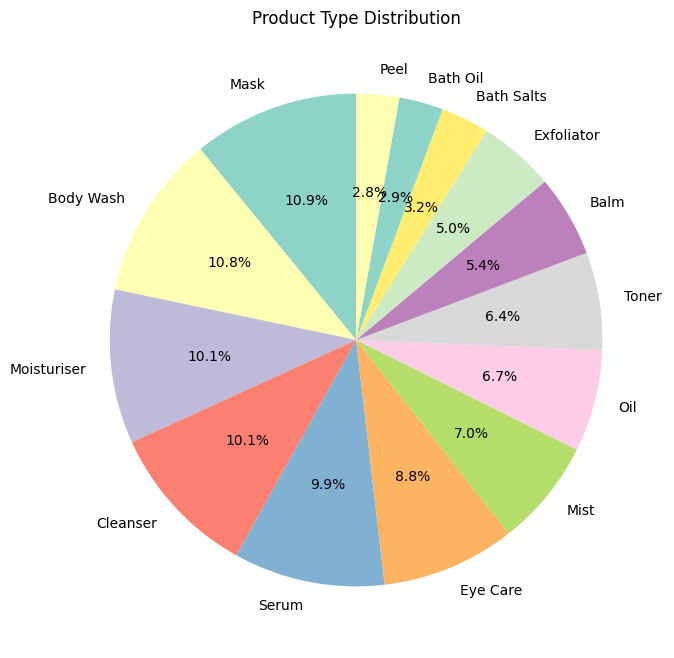

In [ ]:
#product type distribution

data1 = {
    'product_name': data['product_name'].tolist(),
    'product_type': data['product_type'].tolist(),
    'price': data['price'].tolist()
}

df = pd.DataFrame(data1)

# Calculate product type counts
type_counts = df['product_type'].value_counts()

# Plotting a pie chart for product type distribution
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Product Type Distribution')
plt.show()

<ipython-input-16-389655ca7759>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='product_type', y='price', data=df, palette='viridis')


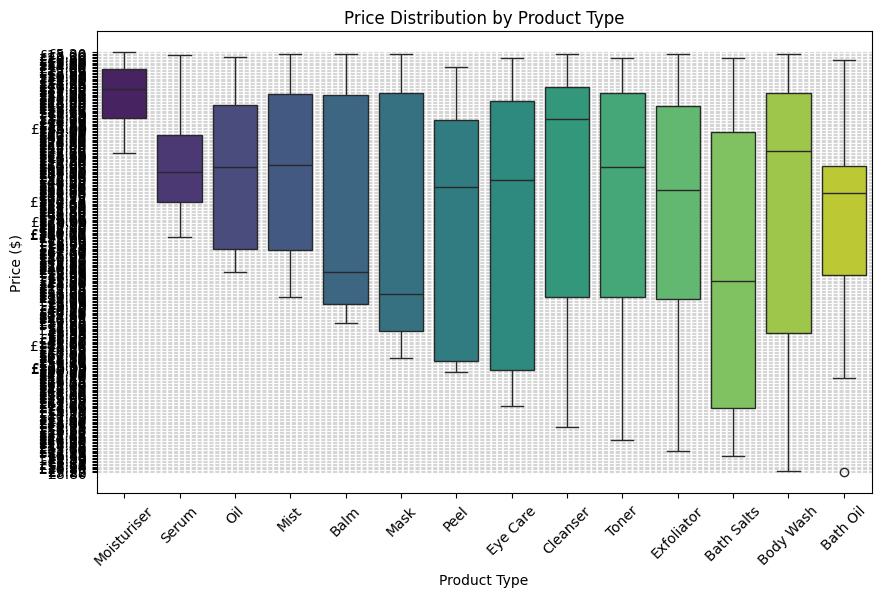

In [ ]:
# Plotting a box plot for price distribution by product type
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_type', y='price', data=df, palette='viridis')
plt.title('Price Distribution by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
brand_list = ["111skin", "a'kin", "acorelle", "adam revolution", "aesop", "ahava", "alchimie forever",
             "algenist", "alpha-h", "ambre solaire", "ameliorate", "american crew", "anthony", "antipodes",
             "apivita", "argentum", "ark skincare", "armani", "aromatherapy associates", "aromaworks", "aromatica",
             "aurelia probiotic skincare", "aurelia skincare",
             "australian bodycare", "avant skincare", "aveda", "aveeno", "avene", "avène",
             "bakel", "balance me", "barber pro", "bareminerals", "barry m cosmetics",
             "baxter of california", "bbb london", "beautypro", "benefit", "benton", "bioderma",
             "bioeffect", "bloom & blossom", "bloom and blossom", "bobbi brown", "bondi sands", "bubble t", "bulldog", "burt's bees",
             "by terry", "carita", "caudalie", "cerave", "chantecaille", "clinique",
             "comfort zone", "connock london", "cosmetics 27", "cosrx", "cowshed", "crystal clear",
             "cult51", "darphin", "dear, klairs", "decleor", "decléor", "dermalogica", "dhc", "doctors formula",
             "dr. brandt", "dr brandt", "dr. hauschka", "dr hauschka", "dr. jackson's", "dr.jart+", "dr. lipp",
             "dr botanicals", "dr dennis", "dr. pawpaw", "ecooking", "egyptian magic",
             "eisenberg", "elemental herbology", "elemis", "elizabeth arden", "embryolisse",
             "emma hardie", "erno laszlo", "espa", "estée lauder", "estee lauder", "eucerin",
             "eve lom", "eve rebirth", "fade out", "farmacy", "filorga", "first aid beauty", "fit", "foreo",
             "frank body", "freezeframe", "gallinée", "garnier", "gatineau", "glamglow", "goldfaden md",
             "green people", "hawkins and brimble", "holika holika", "house 99", "huxley",
             "ilapothecary", "ila-spa", "indeed labs", "inika", "instant effects", "institut esthederm", "ioma", "klorane",
             "j.one", "jack black", "james read", "jason", "jo malone london", "juice beauty", "jurlique",
             "korres", "l:a bruket", "l'oréal men expert", "l'oreal men expert", "l'oréal paris", "l'oreal paris",
             "l’oréal paris", "lab series skincare for men",
             "lancaster", "lancer skincare", "lancôme", "lancome", "lanolips", "la roche-posay", "laura mercier",
             "liftlab", "little butterfly london", "lixirskin", "liz earle", "love boo",
             "löwengrip", "lowengrip", "lumene", "mac", "madara", "mádara", "magicstripes", "magnitone london",
             "mama mio", "mancave", "manuka doctor", "mauli", "mavala", "maybelline", "medik8", "men-u", "menaji", "molton brown", "moroccanoil",
             "monu", "murad", "naobay", "nars", "natio", "natura bissé", "natura bisse",
             "neal's yard remedies", "neom", "neostrata", "neutrogena", "niod", "nip+fab", "nuxe", "nyx",
             "oh k!", "omorovicza", "origins", "ortigia fico", "oskia", "ouai", "pai ", "paula's choice", "payot",
             "perricone md", "pestle & mortar", "pestle and mortar", "peter thomas roth",
             "philosophy", "pierre fabre", "pixi", "piz buin", "polaar", "prai", "project lip",
             "radical skincare", "rapideye", "rapidlash", "real chemistry", "recipe for men",
             "ren ", "renu", "revolution beauty", "revolution skincare", "rituals", "rmk", "rodial", "roger&gallet", "salcura",
             "sanctuary spa", "sanoflore", "sarah chapman", "sea magik", "sepai",
             "shaveworks", "shea moisture", "shiseido", "skin79", "skin authority", "skinceuticals",
             "skinchemists", "skindoctors", "skin doctors", "skinny tan", "sol de janeiro", "spa magik organiks",
              "st. tropez", "starskin", "strivectin", "sukin",
             "svr", "swiss clinic", "talika", "tan-luxe", "tanorganic", "tanworx", "thalgo", "the chemistry brand",
             "the hero project", "the inkey list", "the jojoba company", "the ordinary",
             "the organic pharmacy", "the ritual of namasté", "this works", "too faced", "trilogy", "triumph and disaster",
             "ultrasun", "uppercut deluxe", "urban decay", "uriage", "verso", "vichy",
             "vida glow", "vita liberata", "wahl", "weleda", "westlab", "wilma schumann", "yes to",
             "ysl", "zelens"]
brand_list = sorted(brand_list, key=len, reverse=True)

In [ ]:
data['brand'] = data['product_name'].str.lower()

for k in range(len(data['brand'])):
    for j in brand_list:
        if j in data['brand'].iloc[k]:  # Use .iloc to access DataFrame element by index
            data.loc[k, 'brand'] = data['brand'].iloc[k].replace(data['brand'].iloc[k], j.title())  # Use .loc to modify DataFrame
data

,product_name,product_url,product_type,clean_ingreds,price,X,Y,brand
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"capric triglyceride, cetyl alcohol, propanedio...",£5.20,-79.462952,-229.264893,The Ordinary
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"homosalate, glycerin, octocrylene, ethylhexyl,...",£13.00,-533.685364,-569.151489,Cerave
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"sodium hyaluronate, sodium hyaluronate, panthe...",£6.20,-156.504501,-303.204834,The Ordinary
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"ammonium lactate, c12-15, glycerin, prunus amy...",£22.50,532.435547,472.894714,Ameliorate
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"glycerin, cetearyl alcohol, capric triglycerid...",£16.00,-615.751404,-618.768433,Cerave
...,...,...,...,...,...,...,...,...
1133,Elemis Life Elixirs Embrace Bath and Shower El...,https://www.lookfantastic.com/elemis-life-elix...,Bath Oil,"prunus amygdalus dulcis, tipa-laureth sulfate,...",£55.00,810.392395,-50.436378,Elemis
1134,Love Boo Splendidly Soothing Bath Soak (250ml),https://www.lookfantastic.com/love-boo-splendi...,Bath Oil,"sodium lauroyl, sodium cocoamphoacetate, cocam...",£10.99,248.867157,438.423126,Love Boo
1135,Elemis Life Elixirs Fortitude Bath and Shower ...,https://www.lookfantastic.com/elemis-life-elix...,Bath Oil,"prunus amygdalus dulcis, tipa-laureth sulfate,...",£55.00,814.402161,-63.882950,Elemis
1136,Connock London Kukui Oil Soothing Bath & Showe...,https://www.lookfantastic.com/connock-london-k...,Bath Oil,"capric triglyceride, peg-40 sorbitan peroleate...",£36.00,401.711548,-9.028812,Connock London


In [ ]:
sorted(data.brand.unique())

["A'Kin",
 'Acorelle',
 'Aesop',
 'Ahava',
 'Alchimie Forever',
 'Alpha-H',
 'Ambre Solaire',
 'Ameliorate',
 'Antipodes',
 'Apivita',
 'Ark Skincare',
 'Armani',
 'Aromatherapy Associates',
 'Aromaworks',
 'Aurelia Probiotic Skincare',
 'Aurelia Skincare',
 'Australian Bodycare',
 'Avant Skincare',
 'Aveda',
 'Aveeno',
 'Avene',
 'Avène',
 'Balance Me',
 'Barber Pro',
 'Bareminerals',
 'Bbb London',
 'Beautypro',
 'Benton',
 'Bioderma',
 'Bloom & Blossom',
 'Bloom And Blossom',
 'Bobbi Brown',
 'Bondi Sands',
 'Bubble T',
 'Bulldog',
 "Burt'S Bees",
 'By Terry',
 'Caudalie',
 'Cerave',
 'Chantecaille',
 'Clinique',
 'Comfort Zone',
 'Connock London',
 'Cosrx',
 'Cowshed',
 'Crystal Clear',
 'Darphin',
 'Dear, Klairs',
 'Decléor',
 'Dermalogica',
 'Dhc',
 'Dr Brandt',
 'Dr Dennis',
 'Dr Hauschka',
 'Dr. Brandt',
 'Dr. Hauschka',
 'Dr. Pawpaw',
 'Dr.Jart+',
 'Egyptian Magic',
 'Elemental Herbology',
 'Elemis',
 'Elizabeth Arden',
 'Embryolisse',
 'Emma Hardie',
 'Erno Laszlo',
 'Espa',


In [ ]:
data['brand'] = data['brand'].replace(['Aurelia Probiotic Skincare'],'Aurelia Skincare')
data['brand'] = data['brand'].replace(['Avene'],'Avène')
data['brand'] = data['brand'].replace(['Bloom And Blossom'],'Bloom & Blossom')
data['brand'] = data['brand'].replace(['Dr Brandt'],'Dr. Brandt')
data['brand'] = data['brand'].replace(['Dr Hauschka'],'Dr. Hauschka')
data['brand'] = data['brand'].replace(["L'oreal Paris", 'L’oréal Paris'], "L'oréal Paris")

In [ ]:
import ast

# Function to fix the format of ingredients
def fix_ingredients_format(ingredients_str):
    # Split the string and add quotes around each ingredient
    ingredients_list = [f"'{ing.strip()}'" for ing in ingredients_str.split(',')]
    # Join the list to form a valid Python list representation
    return f"[{', '.join(ingredients_list)}]"

# Apply the function to correct the 'clean_ingreds' column
data['clean_ingreds'] = data['clean_ingreds'].apply(fix_ingredients_format)

# Now, use ast.literal_eval to convert the strings to actual lists
data['clean_ingreds'] = data['clean_ingreds'].apply(ast.literal_eval)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

data['clean_ingreds_str'] = data['clean_ingreds'].apply(lambda x: ' '.join(x))

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['clean_ingreds_str'])

# Extract features (X) and target (y)
X = tfidf_matrix
y = data['product_type']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [ ]:
# Predict product types
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Decision Tree Classifier:", accuracy)

Accuracy of Decision Tree Classifier: 0.43859649122807015


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict product types
y_pred_rf = rf_clf.predict(X_test)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest Classifier:", accuracy_rf)

Accuracy of Random Forest Classifier: 0.5570175438596491


In [ ]:
from sklearn.svm import SVC

# Create SVM Classifier
svm_clf = SVC(kernel='linear', random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predict product types
y_pred_svm = svm_clf.predict(X_test)

# Evaluate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM Classifier:", accuracy_svm)

Accuracy of SVM Classifier: 0.5570175438596491


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Predict product types
y_pred_knn = knn_clf.predict(X_test)

# Evaluate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy of KNN Classifier:", accuracy_knn)

Accuracy of KNN Classifier: 0.4298245614035088


In [ ]:
from sklearn.neural_network import MLPClassifier

# Create MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
# Train the model
mlp_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=100, random_state=42)

In [ ]:

# Predict product types
y_pred_mlp = mlp_clf.predict(X_test)

# Evaluate accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy of MLP Classifier:", accuracy_mlp)

Accuracy of MLP Classifier: 0.5570175438596491


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create Gradient Boosting Classifier
gbm_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbm_clf.fit(X_train, y_train)




GradientBoostingClassifier(random_state=42)

In [ ]:
# Predict product types
y_pred_gbm = gbm_clf.predict(X_test)

# Evaluate accuracy
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("Accuracy of Gradient Boosting Classifier:", accuracy_gbm)

Accuracy of Gradient Boosting Classifier: 0.4956140350877193


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Create Naive Bayes Classifier
nb_clf = MultinomialNB()

# Train the model
nb_clf.fit(X_train, y_train)


MultinomialNB()

In [ ]:

# Predict product types
y_pred_nb = nb_clf.predict(X_test)

# Evaluate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy of Naive Bayes Classifier:", accuracy_nb)

Accuracy of Naive Bayes Classifier: 0.3684210526315789


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
logreg_clf = LogisticRegression(max_iter=100, random_state=42)

# Train the model
logreg_clf.fit(X_train, y_train)



LogisticRegression(random_state=42)

In [ ]:

# Predict product types
y_pred_logreg = logreg_clf.predict(X_test)

# Evaluate accuracy
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy of Logistic Regression Classifier:", accuracy_logreg)

Accuracy of Logistic Regression Classifier: 0.5394736842105263


Creating the recommendation function

The function below recommends products by:

🔍 taking the name of a product as input

🧴 only including products of the same type

📛 not recommending products of the same brand name

➗ calculating cosine similarities and returning top 5 similar products

In [ ]:
def recommender(search):
    cs_list = []
    brands = []
    output = []
    binary_list = []
    idx = data[data['product_name'] == search].index.item()

    # Extract binary ingredient list for the searched product
    for i in ingred_matrix.iloc[idx][1:]:
        binary_list.append(i)

    # Reshape the binary ingredient list as a 1D array
    point1 = np.array(binary_list).reshape(1, -1)
    point1 = [val for sublist in point1 for val in sublist]

    # Get product type and brand of the searched product
    prod_type = data['product_type'][data['product_name'] == search].iat[0]
    brand_search = data['brand'][data['product_name'] == search].iat[0]

    # Filter data by product type
    data_by_type = data[data['product_type'] == prod_type]


    # Calculate cosine similarity with other products of the same type
    for j in range(data_by_type.index[0], data_by_type.index[0] + len(data_by_type)):
        binary_list2 = []
        for k in ingred_matrix.iloc[j][1:]:
            binary_list2.append(k)
        point2 = np.array(binary_list2).reshape(1, -1)
        point2 = [val for sublist in point2 for val in sublist]
        dot_product = np.dot(point1, point2)
        norm_1 = np.linalg.norm(point1)
        norm_2 = np.linalg.norm(point2)
        cos_sim = dot_product / (norm_1 * norm_2)
        cs_list.append(cos_sim)
    data_by_type = pd.DataFrame(data_by_type)
    data_by_type['cos_sim'] = cs_list
    data_by_type = data_by_type.sort_values('cos_sim', ascending=False)
    data_by_type = data_by_type[data_by_type.product_name != search]
    l = 0
    for m in range(len(data_by_type)):
        brand = data_by_type['brand'].iloc[l]
        if len(brands) == 0:
            if brand != brand_search:
                brands.append(brand)
                output.append(data_by_type.iloc[l])
        elif brands.count(brand) < 2:
            if brand != brand_search:
                brands.append(brand)
                output.append(data_by_type.iloc[l])
        l += 1

    return print('\033[1m', 'Recommending products similar to', search,':', '\033[0m'), print(pd.DataFrame(output)[['product_name', 'cos_sim']].head(5))

This recommender function uses cosine similarity based on ingredient matrices (ingred_matrix) to recommend products similar to a searched product (search).
It considers product type and brand to filter and recommend relevant products.
The function prints the top 5 recommended products along with their cosine similarities based on ingredient similarity with the searched product.

In [ ]:
recommender("Origins GinZing™ Energy-Boosting Tinted Moisturiser SPF40 50ml")

 Recommending products similar to Origins GinZing™ Energy-Boosting Tinted Moisturiser SPF40 50ml : 
                                         product_name   cos_sim
87  Clinique Moisture Surge SPF25 Sheertint Hydrat...  0.565322
44              Skin Doctors Sd White & Bright (50ml)  0.382546
54  Clinique Moisture Surge 72-Hour Auto-Replenish...  0.372046
34        Elemis Pro-Collagen Marine Cream SPF30 50ml  0.365339
42  Estée Lauder DayWear Multi-Protection Anti-Oxi...  0.362033


(None, None)

In [ ]:
recommender('Avène Antirougeurs Jour Redness Relief Moisturizing Protecting Cream (40ml)')

 Recommending products similar to Avène Antirougeurs Jour Redness Relief Moisturizing Protecting Cream (40ml) : 
                                          product_name   cos_sim
40           La Roche-Posay Nutritic Intense Rich 50ml  0.408956
87   Clinique Moisture Surge SPF25 Sheertint Hydrat...  0.408248
12         First Aid Beauty Ultra Repair Cream (56.7g)  0.379663
15          First Aid Beauty Ultra Repair Cream (170g)  0.379663
100  Alpha-H Daily Essential Moisturiser Spf50+ (50ml)  0.369800


(None, None)

In [ ]:
recommender('Bondi Sands Everyday Liquid Gold Gradual Tanning Oil 270ml')

 Recommending products similar to Bondi Sands Everyday Liquid Gold Gradual Tanning Oil 270ml : 
                                          product_name   cos_sim
238     Face by Skinny Tan Moisturising Oil Drops 30ml  0.442627
290        Erno Laszlo Detoxifying Cleansing Oil 195ml  0.400000
269                 The Chemistry Brand Glow Oil 100ml  0.353094
272  L’Oréal Paris Extraordinary Oil Sleeping Oil N...  0.345033
232      Clinique Take The Day Off Cleansing Oil 200ml  0.340168


(None, None)

In [ ]:
recommender('Sukin Rose Hip Oil (25ml)')

 Recommending products similar to Sukin Rose Hip Oil (25ml) : 
                                    product_name   cos_sim
257   Trilogy Certified Organic Rosehip Oil 45ml  1.000000
255   Trilogy Certified Organic Rosehip Oil 20ml  1.000000
231  Pai Skincare Rosehip BioRegenerate Oil 30ml  0.577350
292  Natio Ageless Rosehip Oil Cold Pressed 15ml  0.577350
259                     PIXI Rose Oil Blend 30ml  0.392232


(None, None)

In [ ]:
recommender('La Roche-Posay Anthelios Anti-Shine Sun Protection Invisible SPF50+ Face Mist 75ml')

 Recommending products similar to La Roche-Posay Anthelios Anti-Shine Sun Protection Invisible SPF50+ Face Mist 75ml : 
                                          product_name   cos_sim
306  Garnier Ambre Solaire Sensitive Hydrating Hypo...  0.901624
317  Garnier Ambre Solaire Sensitive Hypoallergenic...  0.714590
322  Lumene Nordic Hydra [Lähde] Arctic Spring Wate...  0.360119
315  Lumene Nordic Hydra Lähde Arctic Spring Water ...  0.341704
337  Revolution Skincare x Jake Jamie Tropical Quen...  0.328196


(None, None)

In [ ]:
recommender('Clinique Even Better Clinical Radical Dark Spot Corrector + Interrupter 30ml')

 Recommending products similar to Clinique Even Better Clinical Radical Dark Spot Corrector + Interrupter 30ml : 
                                          product_name   cos_sim
219  Darphin Dark Circle Relief and De-Puffing Eye ...  0.887904
180  Estée Lauder Idealist Pore Minimizing Skin Ref...  0.500390
223       Elizabeth Arden Prevage Advanced Daily Serum  0.453962
154  Estée Lauder Perfectionist Pro Multi-Defense A...  0.434549
177           Lancôme Génifique Double Drop Serum 20ml  0.393573


(None, None)

In [ ]:
recommender("FOREO 'Serum Serum Serum' Micro-Capsule Youth Preserve")

 Recommending products similar to FOREO 'Serum Serum Serum' Micro-Capsule Youth Preserve : 
                                          product_name   cos_sim
200         Holika Holika 3 Seconds Starter (Collagen)  0.429935
160  Caudalie VineActiv Glow Activating Anti-Wrinkl...  0.423659
119  Estée Lauder Advanced Night Repair Synchronize...  0.403278
120  Estée Lauder Advanced Night Repair Synchronize...  0.403278
121  The Ordinary Hyaluronic Acid 2% + B5 Supersize...  0.374327


(None, None)

In [ ]:
recommender('Garnier Organic Argan Mist 150ml')

 Recommending products similar to Garnier Organic Argan Mist 150ml : 
                                          product_name   cos_sim
378   The Ritual of Namasté Urban Hydrating Mist 100ml  0.526137
315  Lumene Nordic Hydra Lähde Arctic Spring Water ...  0.435011
322  Lumene Nordic Hydra [Lähde] Arctic Spring Wate...  0.429801
379         Acorelle Pure Harvest Body Perfume - 100ml  0.415227
307   La Roche-Posay Toleriane Ultra 8 Face Mist 100ml  0.412021


(None, None)

In [ ]:
recommender('Shea Moisture 100% Virgin Coconut Oil Daily Hydration Body Wash 384ml')

 Recommending products similar to Shea Moisture 100% Virgin Coconut Oil Daily Hydration Body Wash 384ml : 
                                           product_name   cos_sim
1093            Caudalie Rose de Vigne Shower Gel 200ml  0.494913
1077           Caudalie Thé des Vignes Shower Gel 200ml  0.494913
1041  Pai Skincare Gentle Genius Camellia and Bergam...  0.393398
1091       Laura Mercier Almond Coconut Body Wash 200ml  0.353553
1023      Aveeno Baby Daily Care Hair & Body Wash 500ml  0.353009


(None, None)

In [ ]:
recommender('JASON Soothing Aloe Vera Body Wash 887ml')

 Recommending products similar to JASON Soothing Aloe Vera Body Wash 887ml : 
                                           product_name   cos_sim
985           Bulldog Lemon & Bergamot Shower Gel 500ml  0.551039
1001    Bulldog Black Pepper & Vetiver Shower Gel 500ml  0.551039
1016      Aveeno Baby Daily Care Baby Gentle Wash 500ml  0.512806
1051           NEOM Tranquillity Body & Hand Wash 250ml  0.505496
1042  REN Clean Skincare Atlantic Kelp and Magnesium...  0.461538


(None, None)

***INFERENCES : The content-based recommendation engine was successfully developed using cosine similarity. The recommendation engine enables users to make better decisions on which product to purchase, as many recommendations contain products that are better value for money. It also has the potential to improve business for less popular brands by recommending their products.***